## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [0]:
from time import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [0]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [0]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw




Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [0]:
print(len(fmnist_dataset_train))
print(len(fmnist_dataset_test))

60000
10000


In [0]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [0]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
       BatchNorm1d-3                  [-1, 100]             200
         LeakyReLU-4                  [-1, 100]               0
           Dropout-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 79,710
Trainable params: 79,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


Your experiments come here:

In [0]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.NLLLoss() 

In [0]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            opt.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # compute predictions
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                y_pred = predictions.max(1)[1].data
                
                ep_val_loss.append(loss.item())
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [0]:
%%time
n_epochs = 20

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 20 took 5.479s
	  training loss: 0.575423
	validation loss: 0.427242
	validation accuracy: 0.847
Epoch 2 of 20 took 5.393s
	  training loss: 0.454649
	validation loss: 0.400475
	validation accuracy: 0.853
Epoch 3 of 20 took 5.349s
	  training loss: 0.423596
	validation loss: 0.378945
	validation accuracy: 0.864
Epoch 4 of 20 took 5.357s
	  training loss: 0.401456
	validation loss: 0.408089
	validation accuracy: 0.846
Epoch 5 of 20 took 5.336s
	  training loss: 0.386756
	validation loss: 0.368881
	validation accuracy: 0.866
Epoch 6 of 20 took 5.326s
	  training loss: 0.379960
	validation loss: 0.365293
	validation accuracy: 0.866
Epoch 7 of 20 took 5.428s
	  training loss: 0.369232
	validation loss: 0.365051
	validation accuracy: 0.871
Epoch 8 of 20 took 5.391s
	  training loss: 0.362097
	validation loss: 0.354023
	validation accuracy: 0.874
Epoch 9 of 20 took 5.347s
	  training loss: 0.358535
	validation loss: 0.368570
	validation accuracy: 0.866
Epoch 10 of 20 took 5.262s
	

In [0]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch number')
    axes[0].legend(fontsize=12)

    axes[1].set_title('Validation accuracy')
    axes[1].set_xlabel('Epoch number')
    axes[1].plot(val_accuracy)

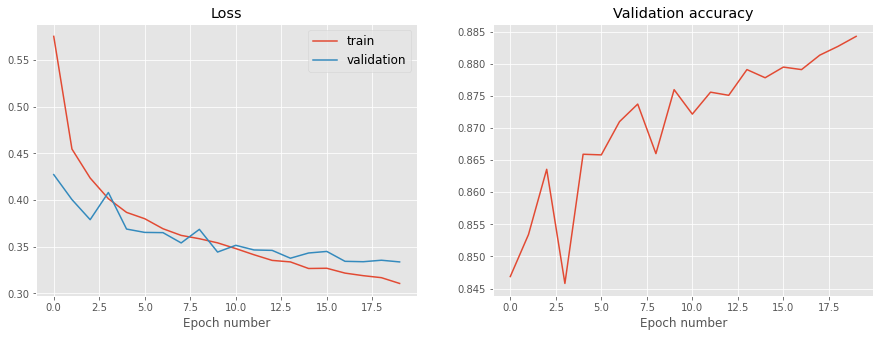

In [0]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accuracy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [0]:
new_train_dataset, _ = torch.utils.data.dataset.random_split(fmnist_dataset_train, [20000, 40000])

new_train_loader = torch.utils.data.DataLoader(new_train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [0]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 200),
            nn.LeakyReLU(),
            nn.Linear(200, num_classes),
            nn.LogSoftmax(),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
         LeakyReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 200]          80,200
         LeakyReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 396,210
Trainable params: 396,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.51
Estimated Total Size (MB): 1.53
----------------------------------------------------------------


In [0]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_func = nn.NLLLoss()

In [0]:
%%time
n_epochs = 100

overfit_train_loss, overfit_val_loss, overfit_val_accuracy = train_model(model, new_train_loader,
                                                                         test_loader, loss_func,
                                                                         opt, n_epochs)

Epoch 1 of 100 took 2.392s
	  training loss: 0.630267
	validation loss: 0.501481
	validation accuracy: 0.817
Epoch 2 of 100 took 2.352s
	  training loss: 0.436916
	validation loss: 0.469051
	validation accuracy: 0.832
Epoch 3 of 100 took 2.304s
	  training loss: 0.389545
	validation loss: 0.438353
	validation accuracy: 0.843
Epoch 4 of 100 took 2.302s
	  training loss: 0.352185
	validation loss: 0.401529
	validation accuracy: 0.857
Epoch 5 of 100 took 2.300s
	  training loss: 0.325698
	validation loss: 0.390275
	validation accuracy: 0.863
Epoch 6 of 100 took 2.319s
	  training loss: 0.313143
	validation loss: 0.405603
	validation accuracy: 0.852
Epoch 7 of 100 took 2.304s
	  training loss: 0.299529
	validation loss: 0.481268
	validation accuracy: 0.844
Epoch 8 of 100 took 2.315s
	  training loss: 0.299109
	validation loss: 0.440983
	validation accuracy: 0.853
Epoch 9 of 100 took 2.279s
	  training loss: 0.269459
	validation loss: 0.390765
	validation accuracy: 0.867
Epoch 10 of 100 too

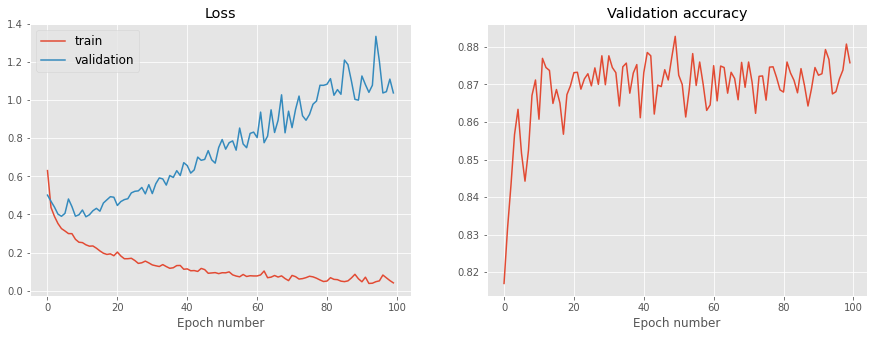

In [0]:
plot_train_process(overfit_train_loss, overfit_val_loss, overfit_val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [0]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(200, num_classes),
            nn.LogSoftmax(),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
       BatchNorm1d-3                  [-1, 400]             800
         LeakyReLU-4                  [-1, 400]               0
           Dropout-5                  [-1, 400]               0
            Linear-6                  [-1, 200]          80,200
       BatchNorm1d-7                  [-1, 200]             400
         LeakyReLU-8                  [-1, 200]               0
           Dropout-9                  [-1, 200]               0
           Linear-10                   [-1, 10]           2,010
       LogSoftmax-11                   [-1, 10]               0
Total params: 397,410
Trainable params: 397,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [0]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
loss_func = nn.NLLLoss()

In [0]:
%%time
n_epochs = 100

fixed_train_loss, fixed_val_loss, fixed_val_accuracy = train_model(model, new_train_loader,
                                                                   test_loader, loss_func,
                                                                   opt, n_epochs)

Epoch 1 of 100 took 2.515s
	  training loss: 0.659174
	validation loss: 0.492537
	validation accuracy: 0.818
Epoch 2 of 100 took 2.523s
	  training loss: 0.502002
	validation loss: 0.434008
	validation accuracy: 0.842
Epoch 3 of 100 took 2.547s
	  training loss: 0.461449
	validation loss: 0.410463
	validation accuracy: 0.856
Epoch 4 of 100 took 2.528s
	  training loss: 0.440120
	validation loss: 0.438942
	validation accuracy: 0.838
Epoch 5 of 100 took 2.543s
	  training loss: 0.418223
	validation loss: 0.408047
	validation accuracy: 0.850
Epoch 6 of 100 took 2.533s
	  training loss: 0.410092
	validation loss: 0.400950
	validation accuracy: 0.852
Epoch 7 of 100 took 2.520s
	  training loss: 0.394394
	validation loss: 0.411663
	validation accuracy: 0.849
Epoch 8 of 100 took 2.484s
	  training loss: 0.391181
	validation loss: 0.405464
	validation accuracy: 0.855
Epoch 9 of 100 took 2.487s
	  training loss: 0.380118
	validation loss: 0.392876
	validation accuracy: 0.860
Epoch 10 of 100 too

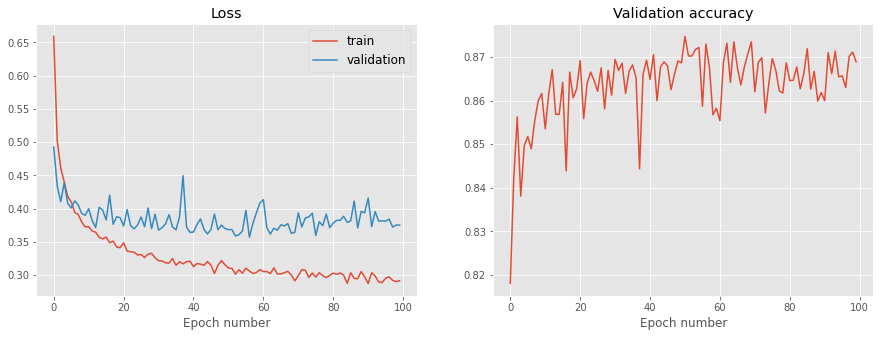

In [0]:
plot_train_process(fixed_train_loss, fixed_val_loss, fixed_val_accuracy)

### Conclusions:

In the first part I have trained a FC network, which achieved desired score. Than I have built a model that overfitted the train dataset. It is demostrated on the plot with validation loss that constantly increased throughtout the process. To some extend it was possible to fix the overfitted network from the previous step by applying some regularization techniques (I used __BatchNormalization__, __Dropout__ and also applied __weight_decay__ in __Adam__ optimizer). We can see that the loss on validation doesn't increase like in overfitted network.